## 1. Imports

In [47]:
#Importamos librerías
import sys
import os 

import numpy as np # Arrays
import pandas as pd # Series and Dataframes

import matplotlib.pyplot as plt 
import seaborn as sns # Advanced Plotting 
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
# from google.colab import files #para importar desde google
# from google.colab import drive

pd.options.display.max_rows = 100
plt.style.use('ggplot') # Beautify Plots 

In [48]:
#A nivel de modelos
from sklearn import model_selection
import xgboost as xgb #este es para hacer decision trees
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics # model evaluation metrics

In [49]:
#Estas funciones son para hacer transformaciones
from scipy import stats
from datetime import datetime

In [50]:
#librería para hacer números random
import random

In [51]:
#json se utiliza para bd de nosql, pero es parecido a los diccionarios de phyton. normalmente tiene esta forma {'ggg`: 'zzzz'}
#Cuando se importa de googlemaps, eso está guardado en un json

import random
import json
from pandas import json_normalize

In [52]:
#Evaluación de rendimiento del modelo
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [53]:
#para poder ver los datos tenemos que montar el drive
# drive.mount('/content/gdrive')

#MODELIZACIÓN

In [54]:
df_modelo1=pd.read_pickle(r"C:\Users\Usuario\OneDrive\Workplace\Portfolio_Projects\TFM_DSC_Easy_Money\data\df_modelo_pk")

## MLC4.1: Train / Test Split

Identificamos que aproximadamente el 80% cae sobre el 2019-01. Se toma la decisión de hacer en entrenamiento con valores del 2018 y la validación con valores de 2019.

Transformamos las dos últimas variables que nos faltan a números, que son las fechas tanto de entrada como mes de venta. 

In [55]:
df_modelo1['año_entrada'] = df_modelo1['entry_month'].dt.year
df_modelo1['mes_entrada'] = df_modelo1['entry_month'].dt.month

In [56]:
df_modelo1['año_venta'] = df_modelo1['month_sale'].dt.year
df_modelo1['mes_venta'] = df_modelo1['month_sale'].dt.month

In [57]:
df_modelo1['mes_venta']

0         5
1         5
2         5
3         4
4         4
         ..
915788    5
915789    5
915790    5
915791    5
915792    5
Name: mes_venta, Length: 915793, dtype: int64

In [58]:
df_modelo1 = df_modelo1.drop(['entry_month', 'month_sale', 'entry_date'], axis=1)

In [59]:
df_modelo1 = df_modelo1.drop(['pk_sale', 'pk_cid'],axis=1) #Viendo en el primer decision tree, estas variables cuando son seleccionadas no aportan aprendizaje
# Se hace la prueba para corroborar esto.

In [60]:
print(df_modelo1.columns)

Index(['Unnamed: 0', 'age', 'net_margin_log', 'salary_scaled',
       'compro_nuevos_productos', 'product_desc_credit_card',
       'product_desc_debit_card', 'product_desc_em_acount',
       'product_desc_emc_account', 'product_desc_funds',
       ...
       'Provincia_Toledo', 'Provincia_Valencia', 'Provincia_Valladolid',
       'Provincia_Vizcaya', 'Provincia_Zamora', 'Provincia_Zaragoza',
       'año_entrada', 'mes_entrada', 'año_venta', 'mes_venta'],
      dtype='object', length=166)


## Undersampling de nuestra variable Target

In [61]:
positive_indices = df_modelo1[df_modelo1['compro_nuevos_productos'] == 1].index
negative_indices = df_modelo1[df_modelo1['compro_nuevos_productos'] == 0].index

In [62]:
num_positive_cases = len(positive_indices)
num_negative_cases = len(negative_indices)

In [63]:
print(num_positive_cases, num_negative_cases)

35304 880489


In [64]:
undersampled_negative_indices = np.random.choice(negative_indices, size=num_positive_cases, replace=False)


In [65]:
undersampled_indices = np.concatenate([positive_indices, undersampled_negative_indices])


In [66]:
df_undersampled = df_modelo1.loc[undersampled_indices]


##Selección de la muestra

In [67]:
target_linked_features = ['compro_nuevos_productos'] #Seleccionamos las columnas que hicimos durante el dataunderstanding

In [68]:
df_val = df_undersampled[df_undersampled['año_venta'] == 2019]
df_dev = df_undersampled[df_undersampled['año_venta'] < 2019]

In [69]:
df_dev.shape

(50742, 166)

In [70]:
df_val.shape

(19866, 166)

In [71]:
df_val.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 19866 entries, 3792 to 902234
Columns: 166 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(7), uint8(157)
memory usage: 4.5 MB


In [72]:
df_dev.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 50742 entries, 100 to 359160
Columns: 166 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(7), uint8(157)
memory usage: 11.5 MB


In [73]:
df_dev_X = df_dev.drop(df_dev[target_linked_features], axis=1)
df_dev_y = df_dev.loc[:, target_linked_features]

In [74]:
df_val_X = df_val.drop(df_val[target_linked_features], axis=1)
df_val_y = df_val.loc[:, target_linked_features]

In [75]:
df_dev_X.head().T

,100,170,182,354,552
Unnamed: 0,100.000000,170.000000,182.000000,354.000000,552.000000
age,46.000000,82.000000,46.000000,73.000000,48.000000
net_margin_log,4.237001,4.146304,4.239887,4.290459,4.373238
salary_scaled,0.007699,0.002668,0.003067,0.004670,0.003571
product_desc_credit_card,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
Provincia_Zaragoza,0.000000,0.000000,0.000000,0.000000,0.000000
año_entrada,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000
mes_entrada,2.000000,5.000000,6.000000,5.000000,2.000000
año_venta,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000


In [76]:
df_dev_y.head().T

,100,170,182,354,552
compro_nuevos_productos,1,1,1,1,1


##Random Holdout

In [77]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        df_dev_X, # X 
                                        df_dev_y, # y
                                        test_size = 0.30, # tamaño del split aleatorio 
                                        random_state = 42
)

In [78]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 35519 entries, 548022 to 630467
Columns: 165 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(6), uint8(157)
memory usage: 7.8 MB


In [79]:
X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 15223 entries, 402782 to 117169
Columns: 165 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(6), uint8(157)
memory usage: 3.3 MB


In [80]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,35519.0,464563.435795,255013.691113,20.000000,238627.50000,507210.000000,663678.000000,893273.000000
age,35519.0,34.538698,13.140787,4.000000,23.00000,32.000000,41.000000,102.000000
net_margin_log,35519.0,4.632037,1.237843,3.511545,4.12552,4.238445,4.369448,9.745535
salary_scaled,35519.0,0.002706,0.004393,0.000000,0.00000,0.002202,0.003793,0.338919
product_desc_credit_card,35519.0,0.028464,0.166296,0.000000,0.00000,0.000000,0.000000,1.000000


In [81]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,15223.0,464017.854562,254330.464379,132.000000,237534.000000,506900.000000,662191.500000,893249.000000
age,15223.0,34.532878,13.126827,4.000000,23.000000,32.000000,42.000000,100.000000
net_margin_log,15223.0,4.623286,1.230398,3.660994,4.123903,4.235555,4.365643,9.588284
salary_scaled,15223.0,0.002753,0.006244,0.000000,0.000000,0.002210,0.003765,0.543763
product_desc_credit_card,15223.0,0.029823,0.170105,0.000000,0.000000,0.000000,0.000000,1.000000


In [82]:
y_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
compro_nuevos_productos,35519.0,0.44486,0.496957,0.0,0.0,0.0,1.0,1.0


In [83]:
y_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
compro_nuevos_productos,15223.0,0.44597,0.497089,0.0,0.0,0.0,1.0,1.0


## Model definition
Para este segundo modelo se hará un Decision Tree

Importación de librería

In [84]:
!conda install python-graphviz -y

"conda" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

##Decision Tree

In [86]:
#DecisionTreeClassifier?

In [87]:
dt = DecisionTreeClassifier(
                        # criterion='gini',
                        # splitter='best',
                        max_depth=4, # Importante, regulará el sobreajuste
                        # min_samples_split=2,
                        # min_samples_leaf=1,
                        # min_weight_fraction_leaf=0.0,
                        # max_features=None,
                        random_state=42,
                        # max_leaf_nodes=None,
                        # min_impurity_decrease=0.0,
                        # min_impurity_split=None,
                        # class_weight=None,
                        # presort=False,  
                )

In [88]:
dt.fit(
    X=X_train, 
    y=y_train, 
    # sample_weight=None, 
    # check_input=True, 
    # X_idx_sorted=None
)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [89]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['No Compra', 'Compra'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

In [90]:
import pydotplus
graph2 = pydotplus.graph_from_dot_data(dot_data)  

In [91]:
graph2.write_png("tree.png")

True

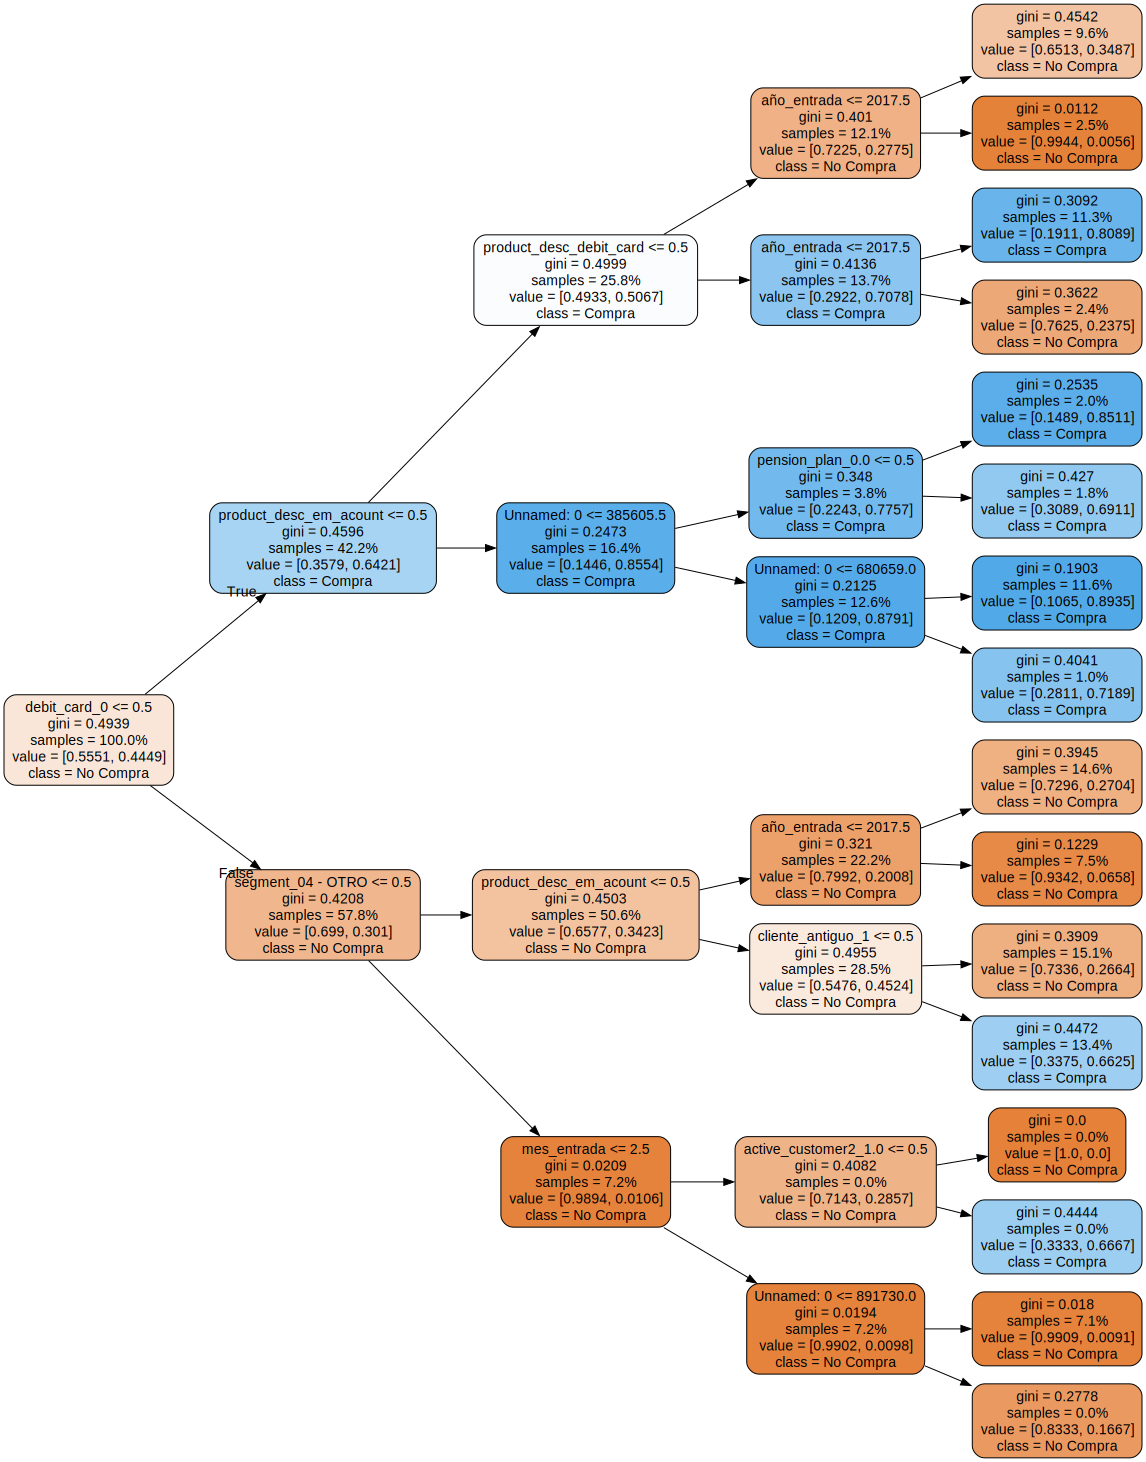

In [92]:
graphviz.Source(dot_data, format = 'png')

## Model evaluation

In [93]:
dt.predict(X_test)

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [94]:
y_pred = pd.DataFrame(dt.predict(X_test), index=y_test.index, columns=['compro_nuevos_prod_Prediction'])

In [95]:
df_results = y_test.join(y_pred, how= 'inner')

In [96]:
df_results.head(10)

,compro_nuevos_productos,compro_nuevos_prod_Prediction
402782,1,0
475185,0,0
558317,1,1
78887,1,0
604401,1,1
188627,0,0
123487,0,0
484441,0,0
521314,1,1
663150,0,0


In [97]:
accuracy = dt.score(X_test, y_test)
print(accuracy)

0.7791499704394665


In [98]:
confusion_matrix = pd.crosstab(df_results['compro_nuevos_productos'],df_results['compro_nuevos_prod_Prediction'])

In [99]:
confusion_matrix

compro_nuevos_prod_Prediction,0,1
compro_nuevos_productos,,
0,7012,1422
1,1940,4849


In [100]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [101]:
(TP+TN)/(TP+TN+FP+FN)

0.7791499704394665

In [102]:
metrics.accuracy_score(df_results['compro_nuevos_productos'],df_results['compro_nuevos_prod_Prediction'])

0.7791499704394665

In [103]:
# Aquí obtenemos el accuracy de forma directa
dt.score(X_test, y_test)

0.7791499704394665

In [104]:
dt.predict_proba(X_test)

array([[0.73359433, 0.26640567],
       [0.65125184, 0.34874816],
       [0.19113987, 0.80886013],
       ...,
       [0.10646573, 0.89353427],
       [0.3374763 , 0.6625237 ],
       [0.65125184, 0.34874816]])

In [105]:
dt.predict_proba(X_test)[:,1]

array([0.26640567, 0.34874816, 0.80886013, ..., 0.89353427, 0.6625237 ,
       0.34874816])

In [106]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index = y_test.index, columns = ['compro_nuevos_productos'])

In [107]:
y_score

,compro_nuevos_productos
402782,0.266406
475185,0.348748
558317,0.808860
78887,0.266406
604401,0.893534
...,...
689367,0.662524
728459,0.009059
626509,0.893534
751948,0.662524


In [108]:
df_results = df_results.join(y_score, lsuffix='_test', rsuffix='_prediccion')

In [109]:
df_results.head()

,compro_nuevos_productos_test,compro_nuevos_prod_Prediction,compro_nuevos_productos_prediccion
402782,1,0,0.266406
475185,0,0,0.348748
558317,1,1,0.808860
78887,1,0,0.266406
604401,1,1,0.893534


In [110]:
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

In [111]:
f1_score = 2 / (1/Precision + 1/Recall)

In [112]:
f1_score

0.7425727411944869

In [113]:
Precision

0.7732419071918354

In [114]:
Recall

0.7142436294005008

In [115]:
metrics.f1_score(y_test, y_pred)

0.7425727411944869

In [116]:
#AUC

metrics.roc_auc_score(df_results['compro_nuevos_productos_test'],df_results['compro_nuevos_productos_prediccion'])

0.833949251416726

In [117]:
#ROC Curve
fpr, tpr, th = metrics.roc_curve(df_results['compro_nuevos_productos_test'],df_results['compro_nuevos_productos_prediccion'])

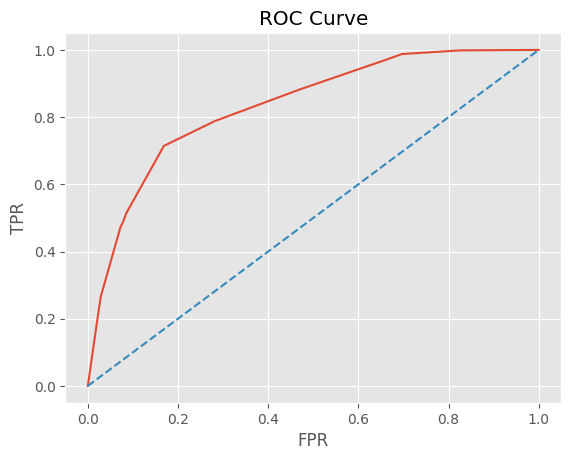

In [118]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle = '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [119]:
for i in range(1,21):
    # intanciar el modelo
    dt2 = DecisionTreeClassifier(max_depth = i, random_state = 42)

    # entrenar

    dt2.fit(X_train,y_train)

    # evaluar

    acc_train = dt2.score(X_train,y_train)
    acc_test = dt2.score(X_test, y_test)

    print(f"Profundidad del arbol: {i}, Acc.train: {np.round(acc_train,3)}, Acc.Test: {np.round(acc_test,3)}")

Profundidad del arbol: 1, Acc.train: 0.675, Acc.Test: 0.672
Profundidad del arbol: 2, Acc.train: 0.675, Acc.Test: 0.672
Profundidad del arbol: 3, Acc.train: 0.729, Acc.Test: 0.726


Profundidad del arbol: 4, Acc.train: 0.785, Acc.Test: 0.779
Profundidad del arbol: 5, Acc.train: 0.789, Acc.Test: 0.787
Profundidad del arbol: 6, Acc.train: 0.812, Acc.Test: 0.805
Profundidad del arbol: 7, Acc.train: 0.825, Acc.Test: 0.817
Profundidad del arbol: 8, Acc.train: 0.837, Acc.Test: 0.825
Profundidad del arbol: 9, Acc.train: 0.847, Acc.Test: 0.829
Profundidad del arbol: 10, Acc.train: 0.857, Acc.Test: 0.827
Profundidad del arbol: 11, Acc.train: 0.867, Acc.Test: 0.826
Profundidad del arbol: 12, Acc.train: 0.878, Acc.Test: 0.821
Profundidad del arbol: 13, Acc.train: 0.889, Acc.Test: 0.819
Profundidad del arbol: 14, Acc.train: 0.901, Acc.Test: 0.814
Profundidad del arbol: 15, Acc.train: 0.913, Acc.Test: 0.81
Profundidad del arbol: 16, Acc.train: 0.925, Acc.Test: 0.809
Profundidad del arbol: 17, Acc.train: 0.936, Acc.Test: 0.806
Profundidad del arbol: 18, Acc.train: 0.945, Acc.Test: 0.801
Profundidad del arbol: 19, Acc.train: 0.954, Acc.Test: 0.799
Profundidad del arbol: 20, Acc.

In [120]:
#Se analiza y con 8 de profundida consideramos que es un buen rango para evitar que el modelo memorice


#Modelo final

In [121]:
dt_final = DecisionTreeClassifier(max_depth = 8, random_state = 42)

In [122]:
dt_final.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, random_state=42)

In [123]:
dt_final.score(X_test,y_test)

0.824607501806477

In [124]:
dt_final.score(df_val_X,df_val_y)

0.8051444679351656

In [125]:
metrics.f1_score(y_test, y_pred)

0.7425727411944869

In [126]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=y_test.index, columns=['compro_nuevos_productos'])

In [127]:
df_results_final = y_test.join(y_test_pred, lsuffix='_test', rsuffix='_prediccion')

In [128]:
df_results_final['Success'] = (df_results_final['compro_nuevos_productos_test'] == df_results_final['compro_nuevos_productos_prediccion']).astype(int)

In [129]:
df_results_final['Success'].mean()

0.7791499704394665

In [130]:
confusion_matrix = pd.crosstab(df_results_final['compro_nuevos_productos_test'],df_results_final['compro_nuevos_productos_prediccion'])

In [131]:
confusion_matrix

compro_nuevos_productos_prediccion,0,1
compro_nuevos_productos_test,,
0,7012,1422
1,1940,4849


#CONCLUSIÓN

En este tercer modelo realizado con la muestra haciendo un undersamplig, genera también un modelo que con un 78% de probabilidad de éxito. 
Teniendo muy balanceados los falsos positivos con los falsos negativos. 

Es una buena manera de evitar que el modelo aprenda de memoria o que directamente diga a todos los clientes que no compran.Sin embargo son pocos los datos que quedaron para poder ejecutar el modelo
